# 비트코인 데이터를 통해 Leveragte Effect가 있는지 확인하고 이에 적합한 GARCH 모델 수립. 

In [22]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics as smg
import statsmodels.tsa as smt
from patsy import dmatrices

import matplotlib.pyplot as plt 
import seaborn as sns

import sklearn

## 1. 데이터 불러오기

Binance(최대 규모 코인 거래소 중 하나)의 비트코인 일별/시간별 데이터

In [2]:
# Binance BTC daily data 2017-08-17 ~ 2019-06-05
binance_d = pd.read_csv('./mydata/Binance_BTCUSDT_d.csv', header=1)
binance_d.dtypes

Date            object
Symbol          object
Open           float64
High           float64
Low            float64
Close          float64
Volume BTC     float64
Volume USDT    float64
dtype: object

In [3]:
# Binance BTC hourly data 2017-08-17 04:00 ~ 2019-06-05 10:00
binance_h = pd.read_csv('./mydata/Binance_BTCUSDT_1h.csv', header=1)
binance_h.dtypes

Date            object
Symbol          object
Open           float64
High           float64
Low            float64
Close          float64
Volume BTC     float64
Volume USDT    float64
dtype: object

In [4]:
binance_d.Date = pd.to_datetime(binance_d.Date)
binance_h.Date = pd.to_datetime(binance_h.Date, format='%Y-%m-%d %I-%p')

binance_d.set_index('Date', inplace=True)
binance_h.set_index('Date', inplace=True)

In [5]:
binance_h = binance_h.iloc[::-1]
binance_d = binance_d.iloc[::-1]

# binance_d = binance_d[::-1] # 이건 순서를 바꾸지만 index가 그대로이다. 
# binance_h = binance_h[::-1]

## 2. Stationarity 확인 - unit root test

** 일단 분석은 Intra day, high frequency인 hourly data 대신 daily data를 이용한다. 

In [8]:
binance_d = binance_d.Close

In [9]:
binance_d.head()

Date
2017-08-17    4285.08
2017-08-18    4108.37
2017-08-19    4139.98
2017-08-20    4086.29
2017-08-21    4016.00
Name: Close, dtype: float64

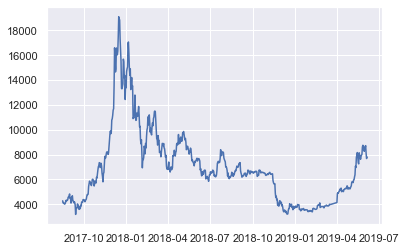

In [21]:
# original data
sns.set(style='darkgrid')
sns.lineplot(data=binance_d)

In [26]:
# ADF(Augumented Dickey-Fuller) unit root test (constant only)
# H0: There is a unit root.

smt.stattools.adfuller(binance_d) # default maxlag=12*(nobs/100)^{1/4}, regression='c'(constant only) autolag='AIC'

# adf(test statistic) 
# pvalue 
# usedlag 
# nobs(number of observations used for the ADF regression and calculation of the critical values)
# critical values
# icbest(The maximized information criterion)

(-2.390625610402797,
 0.14439976067899607,
 20,
 625,
 {'1%': -3.440856177517568, '5%': -2.86617548304384, '10%': -2.56923863104},
 9294.509714313388)

In [27]:
# changing regression options (constant & trend)
smt.stattools.adfuller(binance_d, regression='ct')

(-2.8953000053113334,
 0.16373971722144037,
 20,
 625,
 {'1%': -3.97332828517888, '5%': -3.417537958011904, '10%': -3.13119709966848},
 9293.69918078895)

In [28]:
# changing regression options (constant & linear and quadratic trend)
smt.stattools.adfuller(binance_d, regression='ctt')

(-2.5889110414243364,
 0.5181697235907579,
 20,
 625,
 {'1%': -4.389764184896512,
  '5%': -3.841871578891264,
  '10%': -3.559129170417664},
 9295.381261300612)

In [29]:
# changing regression options (no constant, no trend)
smt.stattools.adfuller(binance_d, regression='nc')

(-0.6971234349573727,
 0.41382208979834006,
 20,
 625,
 {'1%': -2.56932656512, '5%': -1.9414382465105922, '10%': -1.616401883949056},
 9297.952079530667)

All results show that we cannot reject H0 that there is a unit root. 

### 증가율로 변환, unit root 확인

In [32]:
binance_d_return = binance_d.pct_change()
binance_d_return = binance_d_return.iloc[1:]
binance_d_return.head()

Date
2017-08-18   -0.041238
2017-08-19    0.007694
2017-08-20   -0.012969
2017-08-21   -0.017201
2017-08-22    0.005976
Name: Close, dtype: float64

In [33]:
# ADF(Augumented Dickey-Fuller) unit root test (constant only)
# H0: There is a unit root

smt.stattools.adfuller(binance_d_return) 

(-25.399667325520088,
 0.0,
 0,
 644,
 {'1%': -3.440544963888275,
  '5%': -2.866038402294262,
  '10%': -2.569165592859072},
 -2084.109370839511)

In [34]:
# changing regression options (constant & trend)
smt.stattools.adfuller(binance_d_return, regression='ct')

(-25.395773193133316,
 0.0,
 0,
 644,
 {'1%': -3.9728966557887846,
  '5%': -3.4173293485410516,
  '10%': -3.1310744544759865},
 -2082.3539761908655)

In [35]:
# changing regression options (constant & linear and quadratic trend)
smt.stattools.adfuller(binance_d_return, regression='ctt')

(-25.608736160850427,
 0.0,
 0,
 644,
 {'1%': -4.389211715854234,
  '5%': -3.841590900020272,
  '10%': -3.558955608999699},
 -2086.4629755885217)

In [36]:
# changing regression options (no constant, no trend)
smt.stattools.adfuller(binance_d_return, regression='nc')

(-25.368821469042146,
 0.0,
 0,
 644,
 {'1%': -2.56922048445276,
  '5%': -1.941425077439819,
  '10%': -1.616414026597418},
 -2085.080539961283)

All results reject that there is a unit root. 

return series of BTC/USD is now stationary. 

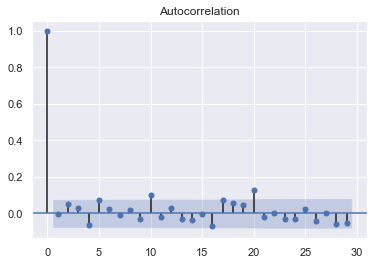

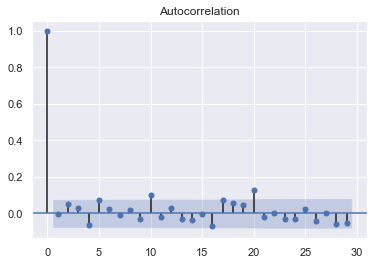

In [37]:
# ACF
smg.tsaplots.plot_acf(binance_d_return)

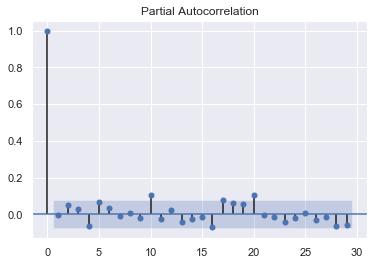

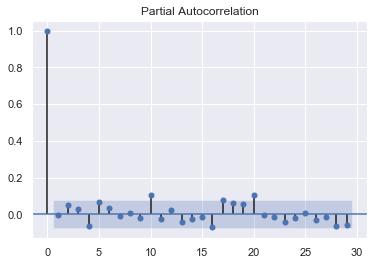

In [38]:
# PACF
smg.tsaplots.plot_pacf(binance_d_return)

## 3. 